In [54]:
import json
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

import alpaca
from alpaca.trading.client import TradingClient
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.historical.stock import StockHistoricalDataClient
from alpaca.trading.stream import TradingStream
from alpaca.data.live.stock import StockDataStream

from alpaca.data.requests import (
    StockBarsRequest,
    StockTradesRequest,
    StockQuotesRequest
)
from alpaca.trading.requests import (
    GetAssetsRequest, 
    MarketOrderRequest, 
    LimitOrderRequest, 
    StopOrderRequest, 
    StopLimitOrderRequest, 
    TakeProfitRequest, 
    StopLossRequest, 
    TrailingStopOrderRequest, 
    GetOrdersRequest, 
    ClosePositionRequest
)
from alpaca.trading.enums import ( 
    AssetStatus, 
    AssetExchange, 
    OrderSide, 
    OrderType, 
    TimeInForce, 
    OrderClass, 
    QueryOrderStatus
)
from alpaca.common.exceptions import APIError

from sklearn.preprocessing import StandardScaler
import pandas as pd

In [71]:
api_key = ""
secret_key = ""

paper = True 

# Below are the variables for development this documents
# Please do not change these variables
trade_api_url = None
trade_api_wss = None
data_api_url = None
stream_data_wss = None

# Fetching Market Data

In [44]:
# setup stock historical data client
stock_historical_data_client = StockHistoricalDataClient(api_key, secret_key, url_override = data_api_url)

In [45]:
symbols = ['META', 'AAPL', 'MSFT', 'AMZN', 'GOOG', 'TSLA']
now = datetime.now(ZoneInfo("America/New_York"))
start_date = datetime(2022, 9, 1)  # Starting from September 1, 2022
end_date = datetime(2023, 3, 1)    # Ending on September 1, 2023

In [60]:
market_data_dict = {}
for symbol in symbols:
    print(f"Fetching {symbol} data...")
    req = StockBarsRequest(
        symbol_or_symbols = [symbol],
        timeframe=TimeFrame(amount = 5, unit = TimeFrameUnit.Minute), 
        start = start_date,     
        end=end_date,                                                        
    )
    market_data_dict[symbol] = stock_historical_data_client.get_stock_bars(req).df.loc[:,["close","volume"]]

Fetching META data...
Fetching AAPL data...
Fetching MSFT data...
Fetching AMZN data...
Fetching GOOG data...
Fetching TSLA data...


In [64]:
market_data_dict['GOOG']

close  volume        bb       sma
symbol timestamp                                                    
GOOG   2022-09-01 08:00:00+00:00  108.40  4977.0       NaN       NaN
       2022-09-01 08:05:00+00:00  108.62   703.0       NaN       NaN
       2022-09-01 08:10:00+00:00  108.41   672.0       NaN       NaN
       2022-09-01 08:15:00+00:00  108.53   652.0       NaN       NaN
       2022-09-01 08:20:00+00:00  108.50  2147.0       NaN       NaN
...                                  ...     ...       ...       ...
       2023-02-28 23:20:00+00:00   90.02   302.0 -0.350084 -0.000588
       2023-02-28 23:40:00+00:00   90.02   401.0 -0.333014 -0.000566
       2023-02-28 23:45:00+00:00   90.07   295.0  0.006611  0.000011
       2023-02-28 23:50:00+00:00   89.94  5694.0 -0.756311 -0.001366
       2023-02-28 23:55:00+00:00   90.08   336.0  0.111203  0.000200

[19604 rows x 4 columns]

In [65]:
market_data_dict['GOOG']['sma'].max()

np.float64(0.038333017916611256)

# Technical Indicator Functions

In [68]:
def calculate_bollinger_bands(data, window=20, num_of_std=2):
    """Calculate Bollinger Bands ratio wrt current price"""
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    bb_ratio = (data - rolling_mean) / (rolling_std * num_of_std)
    return bb_ratio


In [67]:
def calculate_rsi(data, window=20):
    """Calculate Relative Strength Index"""
    delta = data.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [62]:
def calculate_sma(data, window=20):
    """Calculate SMA ratio of current price."""
    rolling_mean = data.rolling(window=window).mean()
    sma = (data / rolling_mean) - 1
    return sma

In [79]:
def calculate_obv(data):
    # Initialize OBV series with the same index as the DataFrame
    obv = [0]
    
    # Loop through each row in the DataFrame
    for i in range(1, len(data)):
        if data['close'].iloc[i] > data['close'].iloc[i - 1]:
            # Price went up, add the volume
            obv.append(obv[-1] + data['volume'].iloc[i])
        elif data['close'].iloc[i] < data['close'].iloc[i - 1]:
            # Price went down, subtract the volume
            obv.append(obv[-1] - data['volume'].iloc[i])
        else:
            # Price stayed the same, OBV remains unchanged
            obv.append(obv[-1]) 
    return obv


In [85]:
def calculate_ema(data, window = 20):
    """Calculate EMA ratio of current price."""
    rolling_mean = data.ewm(span=window, adjust=False).mean()
    ema = (data / rolling_mean) - 1
    return ema

In [92]:
def calculate_macd(prices, short_window=12, long_window=26, signal_window=9):
    """
    Calculate the MACD line, Signal line, and MACD Histogram.
    """
    # Calculate the short and long EMAs
    short_ema = prices.ewm(span=short_window, adjust=False).mean()
    long_ema = prices.ewm(span=long_window, adjust=False).mean()
    
    # Calculate the MACD line
    macd_line = short_ema - long_ema
    
    # Calculate the Signal line
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    
    # Calculate the MACD Histogram
    macd_histogram = macd_line - signal_line
    
    # Combine the results in a DataFrame
    macd_df = pd.DataFrame({
        'MACD': macd_line,
        'Signal': signal_line,
        'Histogram': macd_histogram
    })
    
    return macd_df
    

# Label Generation Functions

In [113]:
def bollinger_detection(bb, thresh = 1):
    """
    Assign labels based on bollinger band crossings.
    """
    # Initialize the result list with zeros
    crossings = [0] * len(bb)
    
    # Loop through each element, starting from the second element (index 1)
    for i in range(1, len(bb)):
        # Check for -1 crossing: previous value <= -1 and current value > -1
        if bb.iloc[i-1] <= -thresh and bb.iloc[i] > -thresh:
            crossings[i] = 1
        # Check for 1 crossing: previous value >= 1 and current value < 1
        elif bb.iloc[i-1] >= thresh and bb.iloc[i] < thresh:
            crossings[i] = 2
    
    return pd.Series(crossings, index=bb.index)

In [114]:
def rsi_detection(rsi, low_thresh = 30, high_thresh = 70):
    """
    Assign labels based on RSI crossings.
    """
    # Initialize the result list with zeros
    crossings = [0] * len(rsi)
    
    # Loop through each element, starting from the second element (index 1)
    for i in range(1, len(rsi)):
        # Check for low crossing: previous value <= low_thresh and current value > low_thresh
        if rsi.iloc[i-1] <= low_thresh and rsi.iloc[i] > low_thresh:
            crossings[i] = 1
        # Check for high crossing: previous value >= 1 and current value < 1
        elif rsi.iloc[i-1] >= high_thresh and rsi.iloc[i] < high_thresh:
            crossings[i] = 2
    
    return pd.Series(crossings, index=rsi.index)

In [115]:
def generate_labels(df):
    """
    Generate trading labels for algorithm. 0 = hold, 1 = buy, 2 = sell.
    """
    labels_bb = bollinger_detection(df["bb"])
    labels_rsi = rsi_detection(df["rsi"])
    
    labels_final = pd.Series(
        [val if val == labels_bb.iloc[i] else 0 for i, val in enumerate(labels_rsi)],
        index=labels_rsi.index
    )
    
    return labels_final
    

# Generating Feature Tables

In [116]:
for symbol in symbols:
    # Calc indicators / features
    market_data_dict[symbol]['bb'] = calculate_bollinger_bands(market_data_dict[symbol]['close'])
    market_data_dict[symbol]['sma'] = calculate_sma(market_data_dict[symbol]['close'])
    market_data_dict[symbol]['rsi'] = calculate_rsi(market_data_dict[symbol]['close'])
    market_data_dict[symbol]['obv'] = calculate_obv(market_data_dict[symbol])
    market_data_dict[symbol]['ema'] = calculate_ema(market_data_dict[symbol]['close'])
    macd_df = calculate_macd(market_data_dict[symbol]['close'])
    market_data_dict[symbol] = pd.concat([market_data_dict[symbol], macd_df], axis=1)
    # TODO: Generate Labels
    labels_df = market_data_dict[symbol].shift(periods=-2)
    market_data_dict[symbol]['label'] = generate_labels(labels_df)
    # TODO: Remove NaN rows
    # TODO: Stack all dataframes
    # TODO: Normalize

<Axes: >

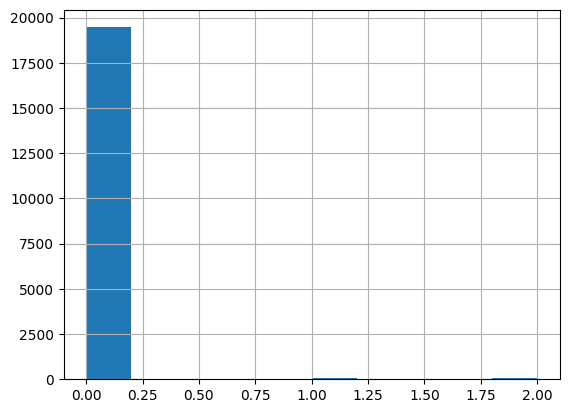

In [118]:
market_data_dict['GOOG']["label"].hist()

In [82]:
market_data_dict['TSLA']

close   volume        bb       sma  \
symbol timestamp                                                          
TSLA   2022-09-01 08:00:00+00:00  270.5400  36561.0       NaN       NaN   
       2022-09-01 08:05:00+00:00  270.9000  10580.0       NaN       NaN   
       2022-09-01 08:10:00+00:00  270.8500   8035.0       NaN       NaN   
       2022-09-01 08:15:00+00:00  270.8000   8216.0       NaN       NaN   
       2022-09-01 08:20:00+00:00  270.6600  10561.0       NaN       NaN   
...                                    ...      ...       ...       ...   
       2023-02-28 23:40:00+00:00  205.3001  17423.0 -0.641543 -0.000885   
       2023-02-28 23:45:00+00:00  205.2500  21761.0 -0.727643 -0.001068   
       2023-02-28 23:50:00+00:00  205.3500  17879.0 -0.366146 -0.000545   
       2023-02-28 23:55:00+00:00  205.3600  18899.0 -0.298774 -0.000441   
       2023-03-01 00:00:00+00:00  205.2300  15284.0 -0.658601 -0.000971   

                                         rsi          obv  
symbol timestamp                                           
TSLA   2022-09-01 08:00:00+00:00         NaN          0.0  
       2022-09-01 08:05:00+00:00  100.000000      10580.0  
       2022-09-01 08:10:00+00:00   87.804878       2545.0  
       2022-09-01 08:15:00+00:00   78.260870      -5671.0  
       2022-09-01 08:20:00+00:00   60.000000     -16232.0  
...                                      ...          ...  
       2023-02-28 23:40:00+00:00   42.725011  170190623.0  
       2023-02-28 23:45:00+00:00   43.961353  170168862.0  
       2023-02-28 23:50:00+00:00   46.543779  170186741.0  
       2023-02-28 23:55:00+00:00   44.497608  170205640.0  
       2023-03-01 00:00:00+00:00   40.277778  170190356.0  

[22931 rows x 6 columns]

In [74]:
market_data_dict['META'].describe()

,close,volume,bb,sma,rsi
count,20788.000000,2.078800e+04,20769.000000,20769.000000,20786.000000
mean,135.203584,2.425950e+05,0.005751,0.000046,50.032532
std,24.815798,5.624684e+05,0.650518,0.006762,14.249304
min,88.300000,1.000000e+02,-2.113733,-0.097785,2.631579
25%,116.465000,2.234250e+03,-0.496115,-0.002225,40.440438
50%,132.995950,4.145650e+04,0.009261,0.000030,50.100020
75%,148.010000,2.919262e+05,0.506198,0.002370,59.913657
max,197.150000,2.352203e+07,2.122992,0.155642,100.000000
